# CellPhoneDB notebook

**Goal**: Use CellPhoneDB to get the list of ligand-receptor pairs detected between different cell types of peripheral blood mononuclear cells (scRNA).

This notebook contains the code that generated the results used for module6 scRNA-lab, part 2, CellPhoneDB.
It is starting from the 25K PMBC scRNA generated by Khag et al in 2018 (https://www.nature.com/articles/nbt.4042). It is the same dataset that is used in the scRNA-lab, part 1 of the module 6 lab (Seurat tutorial: https://satijalab.org/seurat/archive/v3.1/immune_alignment.html). 

To use this notebook:
1) first install python
2) then install jupyter notebook
3) install the necessary python packages (see below)
4) example to install 1 package : pip3 install numpy
5) launch the notebook: open a terminal window; type jupyter notebook ; open a web-browser and go to http://localhost:8888/tree
6) open the notebook (mycellphobeDB.ipynb)

**References**: 
 - https://pypi.org/project/cellphonedb/
 - https://www.sc-best-practices.org/mechanisms/cell_cell_communication.html
 - https://zktuong.github.io/ktplots/articles/vignette.html


In [1]:
# import python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import liana as li
import decoupler as dc

import session_info

In [2]:
# Setting up R dependencies
import anndata2ri
import rpy2
from rpy2.robjects import r
import random

anndata2ri.activate()

%load_ext rpy2.ipython

/var/folders/jn/drzgdc711z58q9wws29jm5t80000gn/T/ipykernel_14107/2969930097.py:7: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.


In [3]:
%%R
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(purrr)
    library(tibble)
})


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In addition: Warning message:
package ‘reticulate’ was built under R version 4.3.3 


In [4]:
# figure settings (size and resolution)
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200, facecolor="white")
sc.set_figure_params(figsize=(5, 5))

In [5]:
# Read in the PBMC scRNA data. Store it in an Annotated data (AnnData) object.
# AnnData is very efficient as storing big matrices from scRNA as it handles well sparsity and unstructured data.
adata = sc.read(
    "kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122"
)
adata

# Extract and store the counts (gene count for each cell) for later use
adata.layers["counts"] = adata.X.copy()

In [6]:
##this describes the object: it contains 15706 cells (columns) and 24673 features that are genes (rows). 
## It has one layer which contains the count data
## the other features stored in obs can be named metadata and are additional information about the dataset
## we will use the cell_type annotate later on in this tutorial
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [7]:
##this step remove bad quality cells that do not contain a minimum of 200 cells per gene or a gene that is detected in only 3 cells or less.
## This is basic preprocessing of scRNA. This is just basic processing for the tutorial. Apply your custom preprocessing and normalization step.
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
# Store the counts for later use
adata.layers["counts"] = adata.X.copy()
# Rename label to condition, replicate to patient
adata.obs = adata.obs.rename({"label": "condition", "replicate": "patient"}, axis=1)
# assign sample
adata.obs["sample"] = (
    adata.obs["condition"].astype("str") + "&" + adata.obs["patient"].astype("str")
)

In [9]:
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [10]:
adata.obs["cell_type"].cat.categories

Index(['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'CD8 T cells',
       'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
      dtype='object')

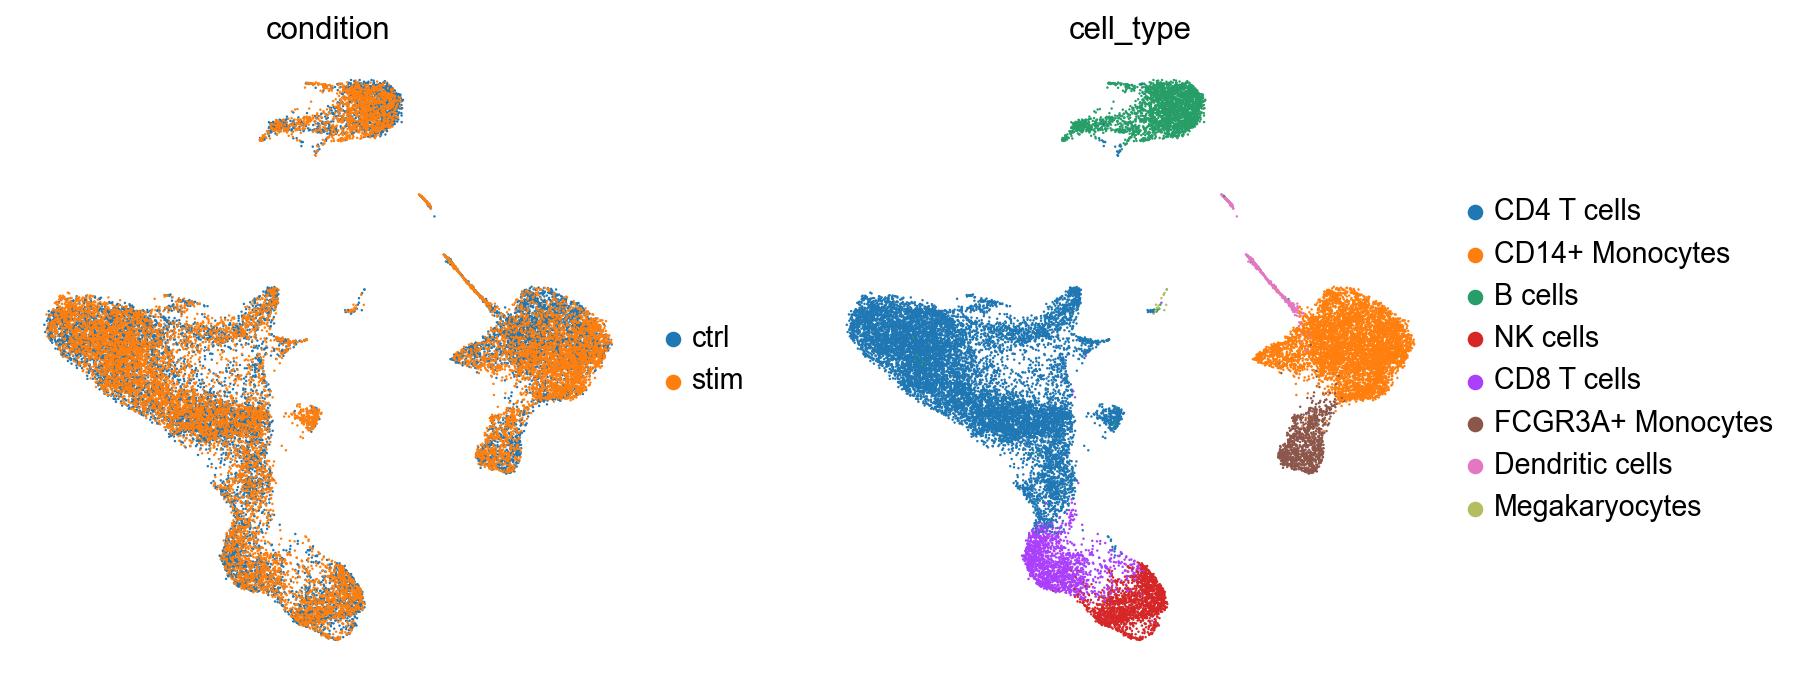

In [11]:
sc.pl.umap(adata, color=["condition", "cell_type"], frameon=False)

In [12]:
## this stem only keep the cells that the stim phenotype: samples were stimulated using interferon

adata_stim = adata[adata.obs["condition"] == "stim"].copy()
adata_stim


AnnData object with n_obs × n_vars = 12301 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'name', 'n_cells'
    uns: 'log1p', 'condition_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [13]:
# import cellphonedb method via liana
from liana.method import cellphonedb

cellphonedb(
    adata_stim, groupby="cell_type", use_raw=False, return_all_lrs=True, verbose=True
)

##This step calls cellphoneDB from liana : https://saezlab.github.io/liana/articles/liana_tutorial.html
## Liana can run different methods for interrogating cell cell communication, we are choosing cellphonedb for this tutorial
## liana takes Seurat and SingleCellExperiment objects as input, containing processed counts and clustered cells.


Using `.X`!
Converting mat to CSR format
227 features of mat are empty, they will be removed.
0.46 of entities in the resource are missing from the data.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/indexing.py:1857: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/liana/method/_pipe_utils/_pre.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Generating ligand-receptor stats for 12301 samples and 15474 features


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:58: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_op

In [14]:
##exploring the results
adata_stim.uns["liana_res"].head()


## each row indicates a ligand-receptor pair with a different combination of source and target for each row. 
## pvalue indicates specificity
## lr_means indicates the magnitude, strenght of the interaction
## lr_means (ligand-receptor) means is the average of ligand mean and receptor mean. The pvalue indicates if this mean is far away from the mean of the null distribution . The null distribution was obtained by permutation of label
## lrs_to_keep indicate rows (ligand-receptor pairs) to keep based on the pvalue
## props: represents the proportion of cells that express the entity


,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lrs_to_keep,lr_means,cellphone_pvals
56717,B2M,B2M,4.431647,1.0,CD3D,CD3D,0.692778,0.620988,CD8 T cells,CD8 T cells,True,2.562212,0.0
55149,B2M,B2M,4.359549,1.0,CD3D,CD3D,0.692778,0.620988,NK cells,CD8 T cells,True,2.526163,0.0
44181,B2M,B2M,4.431647,1.0,KLRD1,KLRD1,0.591819,0.537747,CD8 T cells,NK cells,True,2.511733,0.0
6541,B2M,B2M,4.431647,1.0,CD3D,CD3D,0.520608,0.554421,CD8 T cells,CD4 T cells,True,2.476128,0.0
42613,B2M,B2M,4.359549,1.0,KLRD1,KLRD1,0.591819,0.537747,NK cells,NK cells,True,2.475684,0.0


In [15]:
##filtering the results to only results the source (ligand) from CD8 T cells with a paired receptor on NK or CD4 T cells
## we will use this output to create a network in Cytoscape for it.
df = adata_stim.uns["liana_res"]
df2 = df.loc[(df['source'] == 'CD8 T cells') &  (df['cellphone_pvals'] <= 0.05) & (df['target'] == 'NK cells') | (df['target'] == 'CD4 T cells')]
df2.shape
df2.to_csv("cellphoneDB_final.csv")

In [16]:
##overview of the filtered results:
df2.head()


,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lrs_to_keep,lr_means,cellphone_pvals
44181,B2M,B2M,4.431647,1.0,KLRD1,KLRD1,0.591819,0.537747,CD8 T cells,NK cells,True,2.511733,0.0
6541,B2M,B2M,4.431647,1.0,CD3D,CD3D,0.520608,0.554421,CD8 T cells,CD4 T cells,True,2.476128,0.0
4973,B2M,B2M,4.359549,1.0,CD3D,CD3D,0.520608,0.554421,NK cells,CD4 T cells,True,2.440079,0.0
44175,B2M,B2M,4.431647,1.0,CD247,CD247,0.397906,0.403020,CD8 T cells,NK cells,True,2.414777,0.0
44176,B2M,B2M,4.431647,1.0,KLRC1,KLRC1,0.274590,0.271777,CD8 T cells,NK cells,True,2.353119,0.0


## PART2

<span style="color:blue">We have learned to run CellPhoneDB from the Liana package. </span>

<span style="color:blue">It has a lot of advantages as it is easy to run and the result of cellphoneDB can be aggregated with other methods as well.  </span>

<span style="color:blue">However, the disadvantage of running it from Liana is that we can't have the choices of options or database version. </span>

<span style="color:blue">Therefore in this section, we will learn how to run it from CellPhoneDB directly.  </span>

In [17]:
##import necessary libraries for part2
import pandas as pd
import glob
import os
import sys

In [18]:
##look at different cell phone DB version for ligand-receptor database
from IPython.display import HTML, display
from cellphonedb.utils import db_releases_utils

display(HTML(db_releases_utils.get_remote_database_versions_html()['db_releases_html_table']))


In [19]:
# -- Set version of the database
cpdb_version = 'v5.0.0'

In [20]:
# -- Path where the input files to generate the database are located
#cpdb_target_dir = os.path.join('/home/jovyan/cpdb_tutorial/db/test', cpdb_version)
cpdb_target_dir = os. getcwd()
cpdb_target_dir
#os.listdir(cpdb_target_dir)

'/Users/veronique'

In [21]:
from cellphonedb.utils import db_utils

db_utils.download_database(cpdb_target_dir, cpdb_version)

Downloaded cellphonedb.zip into /Users/veronique
Downloaded complex_input.csv into /Users/veronique
Downloaded gene_input.csv into /Users/veronique
Downloaded interaction_input.csv into /Users/veronique
Downloaded protein_input.csv into /Users/veronique
Downloaded uniprot_synonyms.tsv into /Users/veronique/sources
Downloaded transcription_factor_input.csv into /Users/veronique/sources


<span style="color:blue"> Note: The CellPhoneDB was downloaded in my current directory. For better organization, I moved all these files to a folder that will contain all my files necessary to run CellPhoneDB: /Users/veronique/Downloads/cellphonedb </span>



In [22]:
## I set up the path to this folder here:
pd.set_option('display.max_columns', 100)
mypath = '/Users/veronique/Downloads/cellphonedb'

### Preparing the input data

 - CellPhoneDB takes 5 input:
 - cpdb_file_path = path to the downloaded cellphoneDb database
 - meta_file_path =  path to the downloaded metadata that will tell the different cell types
 - counts_file_path = path to the scRNA count data stored in a h5ad object
 - microenvs_file_path = path to the microenvironment that will tell which cells are from the stimulated samples or not
 - out_path = path where the cellphoneDB results will be stored

In [23]:
## prepare input data
#write the metadata to local computer (we will use later)

adata = sc.read(
    "kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122"
)
adata


tosave = adata.obs[[ "cell_type"]]
tosave.to_csv("metadadata25KPBMC.tsv", sep="\t")

tosave = adata.obs[["cell_type", "label"]]
tosave.to_csv("microenvironment.tsv", sep="\t")



In [24]:
cpdb_file_path = '/Users/veronique/Downloads/cellphonedb/cellphonedb.zip'
meta_file_path = '/Users/veronique/Downloads/cellphonedb/metadadata25KPBMC.tsv'
counts_file_path = '/Users/veronique/Downloads/cellphonedb/kang.h5ad'
microenvs_file_path = '/Users/veronique/Downloads/cellphonedb/microenvironment.tsv'
out_path = '/Users/veronique/Downloads/cellphonedb/'

In [31]:
##run cellphoneDB method 1 (basic method)

from cellphonedb.src.core.methods import cpdb_analysis_method

cpdb_results = cpdb_analysis_method.call(
    cpdb_file_path = cpdb_file_path,           # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,           # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,       # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',               # defines the gene annotation in counts matrix.
    #microenvs_file_path = microenvs_file_path, # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                 # optional: whether to score interactions or not. 
    output_path = mypath,                    # Path to save results    microenvs_file_path = None,
    separator = '|',                           # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    threads = 5,                               # number of threads to use in the analysis.
    threshold = 0.1,                           # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                      # Sets the rounding for the mean values in significan_means.
    debug = False,                             # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_suffix = None                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
)

[ ][CORE][08/06/24-11:32:16][INFO] [Non Statistical Method] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
/Users/veronique/Downloads/cellphonedb/kang.h5ad
/Users/veronique/Downloads/cellphonedb/metadadata25KPBMC.tsv
/Users/veronique/Downloads/cellphonedb/microenvironment.tsv
[ ][CORE][08/06/24-11:32:17][INFO] Running Basic Analysis
[ ][CORE][08/06/24-11:32:17][INFO] Limiting cluster combinations using microenvironments
[ ][CORE][08/06/24-11:32:17][INFO] Building results
[ ][CORE][08/06/24-11:32:17][INFO] Scoring interactions: Filtering genes per cell type..


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 83.67it/s]

[ ][CORE][08/06/24-11:32:17][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 277.35it/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cellphonedb/utils/scoring_utils.py:138: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




[ ][CORE][08/06/24-11:32:18][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|███████████████████████████████████████████| 64/64 [00:02<00:00, 24.28it/s]


Saved means_result to /Users/veronique/Downloads/cellphonedb/simple_analysis_means_result_06_08_2024_113220.txt
Saved deconvoluted to /Users/veronique/Downloads/cellphonedb/simple_analysis_deconvoluted_06_08_2024_113220.txt
Saved deconvoluted_percents to /Users/veronique/Downloads/cellphonedb/simple_analysis_deconvoluted_percents_06_08_2024_113220.txt
Saved interaction_scores to /Users/veronique/Downloads/cellphonedb/simple_analysis_interaction_scores_06_08_2024_113220.txt


<span style="color:blue"> **Note**: The CellPhoneDB output are saved on the local computer in the folder that is defined in the variable "mypath". </span>

In [33]:
##run cellphoneDB method 2 (statistical method)
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

cpdb_results = cpdb_statistical_analysis_method.call(
        cpdb_file_path = cpdb_file_path, 
        meta_file_path = meta_file_path,  
        counts_file_path = counts_file_path, 
        counts_data = 'hgnc_symbol',
        #active_tfs_file_path = active_tf.txt,
        #microenvs_file_path = microenvs_file_path
        score_interactions = True,
        threshold = 0.1,
        output_path = out_path,
        result_precision = 3,                      # Sets the rounding for the mean values in significan_means.
        debug = False,                             # Saves all intermediate tables emplyed during the analysis in pkl format.
         output_suffix = None)




Reading user files...
The following user files were loaded successfully:
/Users/veronique/Downloads/cellphonedb/kang.h5ad
/Users/veronique/Downloads/cellphonedb/metadadata25KPBMC.tsv
[ ][CORE][08/06/24-11:46:09][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:-1 Threads:4 Precision:3
[ ][CORE][08/06/24-11:46:10][INFO] Running Real Analysis
[ ][CORE][08/06/24-11:46:10][INFO] Running Statistical Analysis


100%|███████████████████████████████████████| 1000/1000 [01:42<00:00,  9.72it/s]


[ ][CORE][08/06/24-11:47:53][INFO] Building Pvalues result
[ ][CORE][08/06/24-11:47:53][INFO] Building results
[ ][CORE][08/06/24-11:47:53][INFO] Scoring interactions: Filtering genes per cell type..


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 68.49it/s]

[ ][CORE][08/06/24-11:47:53][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 217.69it/s]


[ ][CORE][08/06/24-11:47:53][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|███████████████████████████████████████████| 64/64 [00:02<00:00, 22.39it/s]


Saved deconvoluted to /Users/veronique/Downloads/cellphonedb/statistical_analysis_deconvoluted_06_08_2024_114756.txt
Saved deconvoluted_percents to /Users/veronique/Downloads/cellphonedb/statistical_analysis_deconvoluted_percents_06_08_2024_114756.txt
Saved means to /Users/veronique/Downloads/cellphonedb/statistical_analysis_means_06_08_2024_114756.txt
Saved pvalues to /Users/veronique/Downloads/cellphonedb/statistical_analysis_pvalues_06_08_2024_114756.txt
Saved significant_means to /Users/veronique/Downloads/cellphonedb/statistical_analysis_significant_means_06_08_2024_114756.txt
Saved interaction_scores to /Users/veronique/Downloads/cellphonedb/statistical_analysis_interaction_scores_06_08_2024_114756.txt


How to interpret the output results
====
* https://cellphonedb.readthedocs.io/en/latest/RESULTS-DOCUMENTATION.html#p-value-pvalues-txt-mean-means-txt-significant-mean-significant-means-txt-and-relevant-interactions-relevant-interactions-txt

* https://cellphonedb.readthedocs.io/en/latest/RESULTS-DOCUMENTATION.html#interpreting-the-outputs


Table guide from: https://github.com/Teichlab/cellphonedb/blob/master/Docs/RESULTS-DOCUMENTATION.md

P-value (pvalues.txt), Mean (means.txt), Significant mean (significant_means.txt)
------------------------------------------------------------------------------------------------
* id_cp_interaction: Unique CellPhoneDB identifier for each interaction stored in the database.
* interacting_pair: Name of the interacting pairs separated by “|”.
* partner A or B: Identifier for the first interacting partner (A) or the second (B). It could be: UniProt (prefix `simple:`) or complex (prefix `complex:`)
* gene A or B: Gene identifier for the first interacting partner (A) or the second (B). The identifier will depend on the input user list.
* secreted: True if one of the partners is secreted.
* Receptor A or B: True if the first interacting partner (A) or the second (B) is annotated as a receptor in our database.
* annotation_strategy: Curated if the interaction was annotated by the CellPhoneDB developers. Otherwise, the name of the database where the interaction has been downloaded from.
* is_integrin: True if one of the partners is integrin.
* rank: Total number of significant p-values for each interaction divided by the number of cell type-cell type comparisons. (Only in significant_means.txt)
* means: Mean values for all the interacting partners: mean value refers to the total mean of the individual partner average expression values in the corresponding interacting pairs of cell types. If one of the mean values is 0, then the total mean is set to 0. (Only in mean.txt)
* p.values: p-values for the all the interacting partners: p.value refers to the enrichment of the interacting ligand-receptor pair in each of the interacting pairs of cell types. (Only in pvalues.txt)
* significant_mean: Significant mean calculation for all the interacting partners. If p.value < 0.05, the value will be the mean. Alternatively, the value is set to 0. (Only in significant_means.txt)

Importantly, the interactions are not symmetric. Partner A expression is considered on the first cluster, and partner B expression is considered on the second cluster. In other words:
* clusterA_clusterB = clusterA expressing partner A and clusterB expressing partner B.
* clusterA_clusterB and clusterB_clusterA  values will be different.


Deconvoluted (deconvoluted.txt)
-------------------------------
* gene_name: Gene identifier for one of the subunits that are participating in the interaction defined in “means.csv” file. The identifier will depend on the input of the user list.
* uniprot: UniProt identifier for one of the subunits that are participating in the interaction defined in “means.csv” file.
* is_complex: True if the subunit is part of a complex. Single if it is not, complex if it is.
* protein_name: Protein name for one of the subunits that are participating in the interaction defined in “means.csv” file.
* complex_name: Complex name if the subunit is part of a complex. Empty if not.
* id_cp_interaction: Unique CellPhoneDB identifier for each of the interactions stored in the database.
* mean: Mean expression of the corresponding gene in each cluster.